In [1]:
import pandas as pd 
import numpy as np
import os
from joblib import dump
import pickle as pkl
import pickle
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_recall_curve
from sklearn.metrics import make_scorer, fbeta_score,  mean_squared_error, r2_score, f1_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, classification_report, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

f2_tuned_scaled_xgb:
Selected features: ['Fwd IAT Total' 'Fwd Packet Length Max' 'Bwd Packet Length Mean'
 'Bwd Packet Length Std' 'Bwd Packets Length Total'
 'Bwd Packet Length Max' 'Packet Length Max' 'Packet Length Mean'
 'Packet Length Std' 'Packet Length Variance' 'Avg Packet Size'
 'Fwd Header Length' 'Avg Fwd Segment Size']

 f2_all_features:
 Selected features: ['Protocol' 'Flow Duration' 'Total Fwd Packets' 'Total Backward Packets'
 'Fwd Packets Length Total' 'Bwd Packets Length Total'
 'Fwd Packet Length Max' 'Fwd Packet Length Min' 'Fwd Packet Length Mean'
 'Fwd Packet Length Std' 'Bwd Packet Length Max' 'Bwd Packet Length Min'
 'Bwd Packet Length Mean' 'Bwd Packet Length Std' 'Flow Bytes/s'
 'Flow Packets/s' 'Flow IAT Mean' 'Flow IAT Std' 'Flow IAT Max'
 'Flow IAT Min' 'Fwd IAT Total' 'Fwd IAT Max' 'Fwd IAT Min'
 'Bwd IAT Total' 'Bwd IAT Mean' 'Bwd IAT Std' 'Bwd IAT Min'
 'Fwd PSH Flags' 'Fwd Header Length' 'Bwd Header Length'
 'Packet Length Min' 'Packet Length Max' 'Packet Length Mean'
 'Packet Length Std' 'PSH Flag Count' 'ACK Flag Count' 'URG Flag Count'
 'Down/Up Ratio' 'Avg Packet Size' 'Init Fwd Win Bytes'
 'Init Bwd Win Bytes' 'Fwd Act Data Packets' 'Fwd Seg Size Min'
 'Active Std' 'Active Min' 'Idle Mean']

optimal features baseline rf: 
Selected features: ['Fwd IAT Total' 'Fwd Packet Length Max' 'Bwd Packet Length Mean'
 'Bwd Packet Length Std' 'Bwd Packet Length Max' 'Packet Length Mean'
 'Packet Length Std' 'Packet Length Variance' 'Avg Packet Size'
 'Fwd Header Length']

optimal features tuned rf:
Selected features: ['Fwd IAT Total' 'Fwd Packet Length Max' 'Bwd Packet Length Mean'
 'Bwd Packet Length Std' 'Bwd Packet Length Max' 'Packet Length Max'
 'Packet Length Mean' 'Packet Length Std' 'Packet Length Variance'
 'Avg Packet Size' 'Fwd Header Length' 'Avg Fwd Segment Size'
 'Avg Bwd Segment Size']

optimal features f2:
    Selected features: ['Bwd Packet Length Mean' 'Bwd Packet Length Std' 'Packet Length Variance'
 'Avg Packet Size']

optimal features f2 scaled: 
Selected features: ['Bwd Packet Length Std' 'Packet Length Variance' 'Avg Packet Size']

In [12]:
train_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/train_df.csv')
eval_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/eval_df.csv')
test_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/test_df.csv')


features = ['Fwd IAT Total', 'Fwd Packet Length Max',
        'Bwd Packet Length Mean', 'Bwd Packet Length Std',
        'Bwd Packets Length Total', 'Bwd Packet Length Max',
        'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
        'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length',
        'Avg Fwd Segment Size', 'Avg Bwd Segment Size']


#X_train = train_df[selected_features]  # Features from the training data
X_train = train_df.drop(['Label', 'Attack'], axis=1)
X_train_selected_feat = train_df[features]
y_train = train_df['Attack'] 

#X_eval = eval_df[selected_features]  # Features from the evaluation data
X_eval = eval_df.drop(['Label', 'Attack'], axis=1)
y_eval = eval_df['Attack']

#X_test = test_df[selected_features]
X_test = test_df.drop(['Label', 'Attack'], axis=1)
y_test = test_df['Attack']

# Initialize scaler
scaler = StandardScaler()

# Scale the features
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

# Applying the 'trained' scaler on eval and test
X_eval[X_eval.columns] = scaler.transform(X_eval[X_eval.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

# feature reduction with crossvalidation

## summarized results

In [10]:
def load_object(file_path):
    """Load a GridSearchCV, RandomizedSearchCV, or RFECV object from a file."""
    with open(file_path, 'rb') as file:
        search = pickle.load(file)
    return search

def get_model_info(search):
    """Extract model type and features from the search object."""
    model_info = {
        'Model Type': type(search.best_estimator_).__name__ if hasattr(search, 'best_estimator_') else type(search.estimator).__name__,
        'Search Type': 'GridSearchCV' if isinstance(search, GridSearchCV) else ('RandomizedSearchCV' if isinstance(search, RandomizedSearchCV) else 'RFECV')
    }
    return model_info

def summarize_search(search, model_name):
    """Summarize the search or RFECV results and return as a dictionary."""
    model_info = get_model_info(search)
    
    if model_info['Search Type'] == 'RFECV':
        optimal_features_mask = search.support_

        if 'all' in model_name:
            feature_names = X_train.columns.tolist()
            selected_features = np.array(feature_names)[optimal_features_mask]
        else:
            feature_names = X_train_selected_feat.columns.tolist()
            selected_features = np.array(feature_names)[optimal_features_mask]
        
        summary = {
            'Model': model_name,
            ''
            'Optimal Number of Features': search.n_features_,
            'Selected Features': selected_features,
            'Number of input features': len(optimal_features_mask),
            'Model Type': model_info['Model Type'],
            'Search Type': model_info['Search Type']
        }
    else:
        summary = {
            'Model': model_name,
            'Best Parameters': search.best_params_,
            'Best Score': search.best_score_,
            'Scorer': search.scorer_,
            'Features': model_info['Features'],
            'Model Type': model_info['Model Type'],
            'Search Type': model_info['Search Type']
        }
    return summary

def load_and_summarize_searches(file_paths, model_names):
    """Load multiple search objects, summarize their results, and store in a DataFrame."""
    summaries = []
    for file_path, model_name in zip(file_paths, model_names):
        try:
            search = load_object(file_path)
            summary = summarize_search(search, model_name)
            summaries.append(summary)
        except Exception as e:
            print(f"Error loading {model_name} from {file_path}: {e}")
    return pd.DataFrame(summaries)


In [11]:
# summarizing rfecv results
file_paths = [
    '../crossvalidation/rfecv_all_feat_RF.pkl',
    '../crossvalidation/rfecv_selected_feat_RF.pkl',
    '../crossvalidation/rfecv_all_feat_XGB.pkl',
    '../crossvalidation/rfecv_selected_feat_XGB.pkl',
]
model_names = [
    'Random Forest with all features',
    'Random Forest with selected features',
    'XGBoost with all features',
    'XGBoost with selected features',
]

summaries_df = load_and_summarize_searches(file_paths, model_names)
#summaries_df.to_csv('/work/SarahHvidAndersen#6681/DataScience_project/output/rfecv_results.csv', index = False)


Error loading Random Forest with selected features from ../crossvalidation/rfecv_selected_feat_RF.pkl: name 'X_train_selected_feat' is not defined
Error loading XGBoost with selected features from ../crossvalidation/rfecv_selected_feat_XGB.pkl: name 'X_train_selected_feat' is not defined


In [5]:
summaries_df

,Model,Optimal Number of Features,Selected Features,Number of input features,Model Type,Search Type
0,Random Forest with all features,3,"[Bwd Packet Length Std, Packet Length Std, Avg...",77,RandomForestClassifier,RFECV
1,Random Forest with selected features,3,"[Bwd Packet Length Std, Packet Length Variance...",14,RandomForestClassifier,RFECV
2,XGBoost with all features,46,"[Protocol, Flow Duration, Total Fwd Packets, T...",77,XGBClassifier,RFECV
3,XGBoost with selected features,13,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",14,XGBClassifier,RFECV


In [6]:
# Define a classifier
clf = RandomForestClassifier(n_estimators=100, max_depth = None, min_samples_leaf=2,
                                        min_samples_split = 2, random_state=42)
# better to use tuned version for feature selection, that should be optimal for all features already

# Define the scorer, F2 Score, could be too high, maybe experiment with F1.5
f2_scorer = make_scorer(fbeta_score, beta=2, average='binary')

# Create the RFE object and compute a cross-validated score.
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5), scoring=f2_scorer)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
# tuned model Optimal number of features : 13
# tuned for f2 score: Optimal number of features : 3

Optimal number of features : 3


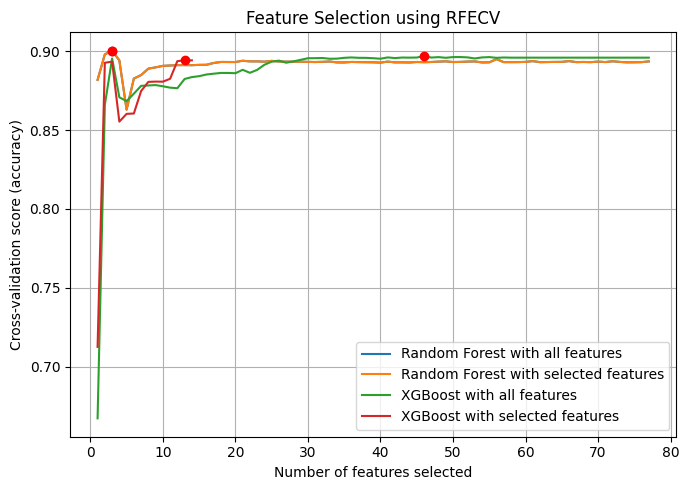

In [13]:
# plot all together
filenames = ['../crossvalidation/rfecv_all_feat_RF.pkl',
            '../crossvalidation/rfecv_selected_feat_RF.pkl',
            '../crossvalidation/rfecv_all_feat_XGB.pkl',
            '../crossvalidation/rfecv_selected_feat_XGB.pkl']


# Load all RFECV objects
rfecv_objects = []
for filename in filenames:
    with open(filename, 'rb') as file:
        rfecv = pickle.load(file)
        rfecv_objects.append(rfecv)

# Plotting setup
plt.figure(figsize=(7, 5))

for i, rfecv in enumerate(rfecv_objects):
    # Extract mean test scores
    mean_scores = np.array(rfecv.cv_results_['mean_test_score'])
    # Plot mean test scores
    plt.plot(range(1, len(mean_scores) + 1), mean_scores, label=model_names[i])
    # Highlight peak
    peak_index = np.argmax(mean_scores)
    plt.scatter(peak_index + 1, mean_scores[peak_index], color='red', zorder=5)

# Enhancing the plot
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.title('Feature Selection using RFECV')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/work/SarahHvidAndersen#6681/DataScience_project/output/feature_exploration_plots')
plt.show()

In [ ]:

# Initialize the XGBoost classifier
#xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb = XGBClassifier(objective='binary:logistic',use_label_encoder=False,
                                colsample_bytree=1.0, gamma=0.5,learning_rate=0.3, max_depth=10,
                                n_estimators=350, subsample=0.5, eval_metric='logloss')
                                
# Define the scorer, F2 Score, could be too high, maybe experiment with F1.5
f2_scorer = make_scorer(fbeta_score, beta=2, average='binary')
# Create the RFE object with cross-validation
rfecv = RFECV(estimator=xgb, step=1, cv=StratifiedKFold(5), scoring=f2_scorer)
rfecv.fit(X_train, y_train)

# Extract mean test scores from cv_results_
print("Optimal number of features : %d" % rfecv.n_features_)

In [ ]:

model = XGBClassifier(objective='binary:logistic', use_label_encoder=False,
colsample_bytree= 1.0, gamma = 0.5, learning_rate= 0.3, max_depth= 10, n_estimators= 350, subsample= 0.5, eval_metric='logloss')
model.fit(X_train, y_train)

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(model, ax=ax, importance_type='weight') # weight, gain
plt.show()

# permutation

In [8]:
# xgboost fitted
model = XGBClassifier(objective='binary:logistic',use_label_encoder=False,
                                colsample_bytree=1.0, gamma=0.5,learning_rate=0.3, max_depth=10,
                                n_estimators=350, subsample=0.5, eval_metric='logloss')
model.fit(X_train, y_train)

# Define the F2 score as a custom scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# permutate
result = permutation_importance(model, X_eval, y_eval, scoring=f2_scorer, n_repeats=10, random_state=42, n_jobs=-1)

In [9]:
positive_features = []

# result.importances_mean provides the average decrease in model score due to the shuffling
feature_importance = result.importances_mean
for i in range(X_eval.shape[1]):
    if feature_importance[i] > 0:
        print(f"Feature: {X_eval.columns[i]}, Importance: {feature_importance[i]}")
        positive_features.append(X_eval.columns[i])


Feature: Protocol, Importance: 4.115732551512874e-05
Feature: Flow Duration, Importance: 0.00014527412137484985
Feature: Total Backward Packets, Importance: 0.00019618566479168154
Feature: Fwd Packets Length Total, Importance: 0.00046840522858414556
Feature: Fwd Packet Length Max, Importance: 0.001664934368529658
Feature: Fwd Packet Length Mean, Importance: 0.0009334074290071714
Feature: Bwd Packet Length Max, Importance: 0.0004984935700002247
Feature: Bwd Packet Length Mean, Importance: 0.0017252577365334475
Feature: Bwd Packet Length Std, Importance: 0.007478422099781268
Feature: Flow Bytes/s, Importance: 0.0008020678507176914
Feature: Flow IAT Std, Importance: 0.0018712483801819114
Feature: Flow IAT Max, Importance: 0.00016355248299727566
Feature: Flow IAT Min, Importance: 0.0008769025568955535
Feature: Fwd IAT Total, Importance: 0.0014596188705997327
Feature: Fwd IAT Mean, Importance: 0.00012708665508703865
Feature: Fwd IAT Std, Importance: 0.00015606848126600292
Feature: Fwd IAT M

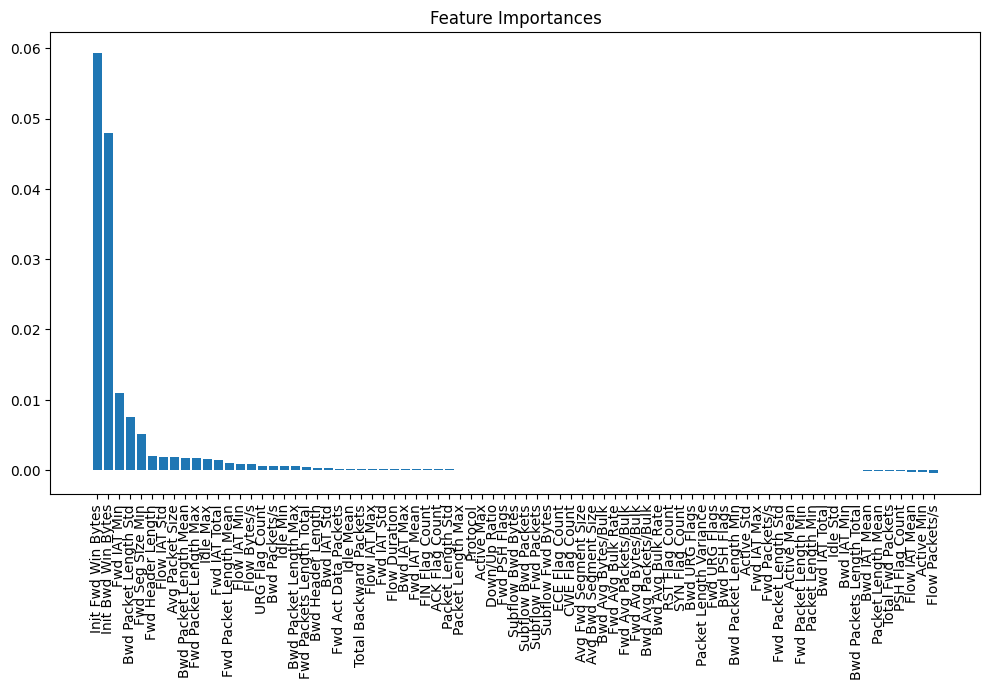

In [10]:
# plot sorted feature importance
indices = np.argsort(feature_importance)[::-1]  # Sort features by importance

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_eval.shape[1]), feature_importance[indices])
plt.xticks(range(X_eval.shape[1]), X_eval.columns[indices], rotation=90)
#plt.tight_layout()
plt.savefig("/work/SarahHvidAndersen#6681/DataScience_project/output/feature_exploration_plots/xgb_permuation_all_features.png") 
plt.show()

In [5]:
# RF fitted
model = RandomForestClassifier(n_estimators=100, max_depth = None, min_samples_leaf=2,
                                        min_samples_split = 2, random_state=42)
model.fit(X_train, y_train)

# Define the F2 score as a custom scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# permutate
result = permutation_importance(model, X_eval, y_eval, scoring=f2_scorer, n_repeats=10, random_state=42, n_jobs=-1)

In [12]:
positive_features_rf = []

# result.importances_mean provides the average decrease in model score due to the shuffling
feature_importance = result.importances_mean
for i in range(X_eval.shape[1]):
    if feature_importance[i] > 0:
        print(f"Feature: {X_eval.columns[i]}, Importance: {feature_importance[i]}")
        positive_features_rf.append(X_eval.columns[i])

Feature: Fwd Packet Length Std, Importance: 9.834242746308286e-05
Feature: Bwd Packet Length Min, Importance: 3.254052522992934e-05
Feature: Bwd Packet Length Std, Importance: 0.00028081109725676124
Feature: Fwd IAT Min, Importance: 0.0060978296718702365
Feature: Bwd IAT Std, Importance: 0.00012992682282918498
Feature: Bwd IAT Max, Importance: 0.00014301956487929867
Feature: Bwd IAT Min, Importance: 9.408919092160906e-05
Feature: Fwd PSH Flags, Importance: 4.418681789608581e-06
Feature: Fwd Header Length, Importance: 0.0005273406097458855
Feature: SYN Flag Count, Importance: 1.3256045368825741e-05
Feature: URG Flag Count, Importance: 0.00020471247558837558
Feature: Avg Bwd Segment Size, Importance: 0.00010487087822075303
Feature: Init Fwd Win Bytes, Importance: 0.0022126742704092206
Feature: Init Bwd Win Bytes, Importance: 6.50762544675998e-05
Feature: Fwd Seg Size Min, Importance: 0.00047080945448122467
Feature: Idle Std, Importance: 4.4186817896085806e-05
Feature: Idle Max, Importanc

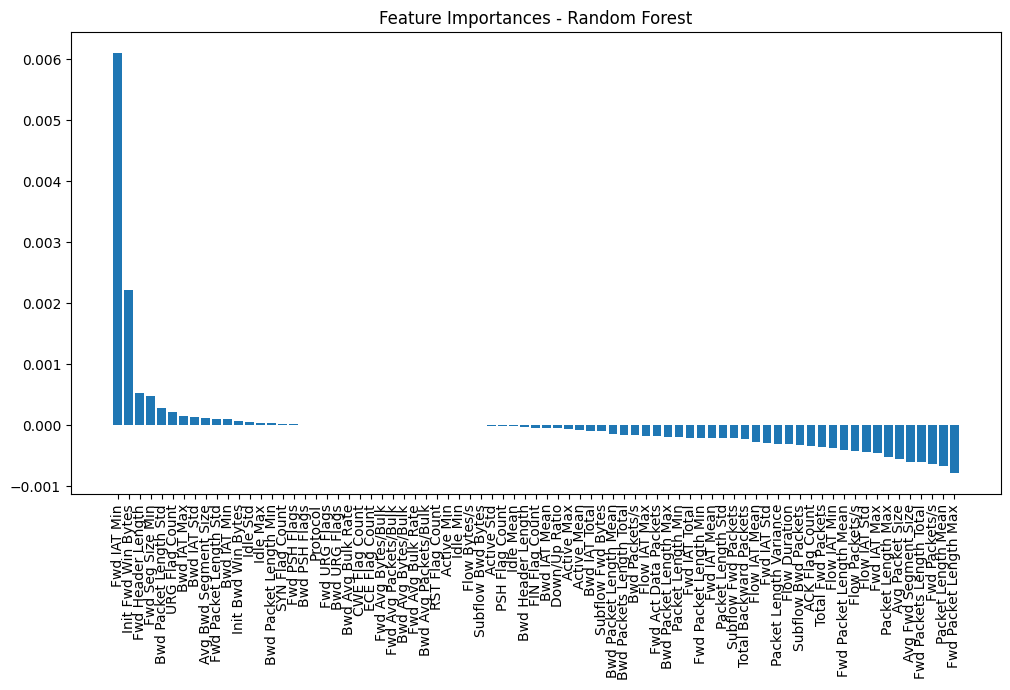

In [13]:
indices = np.argsort(feature_importance)[::-1]  # Sort features by importance

plt.figure(figsize=(12, 6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(X_eval.shape[1]), feature_importance[indices])
plt.xticks(range(X_eval.shape[1]), X_eval.columns[indices], rotation=90)
plt.savefig("/work/SarahHvidAndersen#6681/DataScience_project/output/feature_exploration_plots/rf_permuation_all_features.png") 
plt.show()

In [14]:
positive_features

['Protocol',
 'Flow Duration',
 'Total Backward Packets',
 'Fwd Packets Length Total',
 'Fwd Packet Length Max',
 'Fwd Packet Length Mean',
 'Bwd Packet Length Max',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Std',
 'Flow Bytes/s',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Total',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Min',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Fwd PSH Flags',
 'Fwd Header Length',
 'Bwd Header Length',
 'Bwd Packets/s',
 'Packet Length Max',
 'Packet Length Std',
 'FIN Flag Count',
 'ACK Flag Count',
 'URG Flag Count',
 'Down/Up Ratio',
 'Avg Packet Size',
 'Init Fwd Win Bytes',
 'Init Bwd Win Bytes',
 'Fwd Act Data Packets',
 'Fwd Seg Size Min',
 'Active Max',
 'Idle Mean',
 'Idle Max',
 'Idle Min']

In [15]:
positive_features_RF

NameError: name 'positive_features_RF' is not defined

# fit and compare models

In [ ]:
def train_and_save(model, X_train, y_train, filename):
    """Train a model and save it to a specified filename."""
    model.fit(X_train, y_train)
    dump(model, filename)
    return model
    
def evaluate(model, X, y, model_name, feature_subset, beta=2):
    probabilities = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, probabilities)
    
    # Calculating F scores for the given beta
    f_scores = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    best_idx = np.nanargmax(f_scores)  # Using nanargmax to ignore NaNs in the calculation
    best_threshold = thresholds[best_idx]
    predictions = (probabilities >= best_threshold).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions, zero_division=0)
    rec = recall_score(y, predictions, zero_division=0)
    f1 = f1_score(y, predictions, zero_division=0)
    f2 = (1 + 2**2) * (prec * rec) / ((2**2 * prec + rec))
    roc_auc = roc_auc_score(y, probabilities)

    # Store performances
    performances.append({
        'model': model_name + '_' + str(len(feature_subset)),
        'features': feature_subset,
        'threshold': best_threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'f2': f2,
        'roc_auc': roc_auc,
        'beta': beta
    })
    
    report = classification_report(y, predictions)
    cm = confusion_matrix(y, predictions)

    # Save the classification report as TXT
    report_path = f'../models/feature_test/{model_name}_classification_report.txt'
    with open(report_path, 'w') as f:
        f.write(report)

    # Generate and save onfusion matrix as JPEG
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix for {model_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'])
    plt.tight_layout()
    
    matrix_path = f'../models/feature_test/{model_name}_confusion_matrix.jpeg'
    plt.savefig(matrix_path)
    plt.close(fig)
    print(f"Saved confusion matrix for {model_name} at {matrix_path}")

def test_feature_subsets(model, feature_subset, X_train, y_train, X_eval, y_eval, model_name):
    X_train_subset = X_train[feature_subset]
    X_eval_subset = X_eval[feature_subset]

    filename = f"../models/feature_test/{model_name}.joblib"
    trained_model = train_and_save(model, X_train_subset, y_train, filename) # fitting the subset
    evaluate(trained_model, X_eval_subset, y_eval, f"{model_name}", feature_subset)
    return

In [ ]:
# Selecting features with non-negative importance > 0.01
#feature_subset = [feat for feat, imp in importance_scores.items() if imp > 0.01]

all_features = ['Fwd IAT Total', 'Fwd Packet Length Max',
        'Bwd Packet Length Mean', 'Bwd Packet Length Std',
        'Bwd Packets Length Total', 'Bwd Packet Length Max',
        'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
        'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length',
        'Avg Fwd Segment Size', 'Avg Bwd Segment Size']
        
xgb_feature_subset_permutation = ['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
 'Packet Length Std', 'Avg Packet Size', 'Fwd Header Length']
xgb_feature_subset_rfecv = ['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
 'Bwd Packets Length Total','Bwd Packet Length Max', 'Packet Length Max', 'Packet Length Mean',
 'Packet Length Std', 'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length', 'Avg Fwd Segment Size']

rf_feature_subset_rfecv =  ['Bwd Packet Length Std', 'Packet Length Variance', 'Avg Packet Size']
rf_feature_subset_permutation = ['Bwd Packet Length Std', 'Fwd IAT Total', 'Fwd Header Length', 'Avg Packet Size']
rf_feature_subset_perm_pos = ['Fwd IAT Total', 'Bwd Packet Length Std', 'Bwd Packets Length Total',
 'Packet Length Mean','Avg Packet Size', 'Fwd Header Length', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

In [ ]:
perf_df = plot_model_performance(perf_df, metric='f2') # rf14

In [ ]:
performances = []

# XGBoost
xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False,
colsample_bytree= 1.0, gamma = 0.5, learning_rate= 0.3, max_depth= 10, n_estimators= 350, subsample= 0.5, eval_metric='logloss')

test_feature_subsets(xgb_model, xgb_feature_subset_permutation, X_train, y_train, X_eval, y_eval, model_name = 'XGB_perm')
test_feature_subsets(xgb_model, xgb_feature_subset_rfecv, X_train, y_train, X_eval, y_eval, model_name = 'XGB_rfecv')
test_feature_subsets(xgb_model, all_features, X_train, y_train, X_eval, y_eval, model_name = 'XGB_all_features')


In [ ]:
# random forest
rf_model = RandomForestClassifier(n_estimators=110, max_depth = 40, min_samples_leaf=1,
                                        min_samples_split = 10, random_state=42)

test_feature_subsets(rf_model, rf_feature_subset_permutation, X_train, y_train, X_eval, y_eval, model_name = 'RF_perm')
test_feature_subsets(rf_model, rf_feature_subset_rfecv, X_train, y_train, X_eval, y_eval, model_name = 'RF_rfecv')
test_feature_subsets(rf_model, rf_feature_subset_perm_pos, X_train, y_train, X_eval, y_eval, model_name = 'RF_perm_pos')
test_feature_subsets(rf_model, all_features, X_train, y_train, X_eval, y_eval, model_name = 'RF_all_features')


In [ ]:

perf_df = pd.DataFrame(performances)
perf_df.to_csv('../output/feature_reduction_results.csv', index = False)

In [ ]:
perf_df = pd.read_csv('../output/feature_reduction_results.csv')

In [ ]:
def plot_model_performance(perf_df, metric='f2'):
    #perf_df = pd.DataFrame(performances)
    
    # sort the full DataFrame based on the order of the test set performance
    perf_df['model'] = pd.Categorical(perf_df['model'], ordered=True)
    #perf_df = perf_df.sort_values('model')

    # Set up the plot
    sns.set_style('whitegrid')
    scatter_plot = sns.scatterplot(data=perf_df, 
                                   x=metric, 
                                   y='model',
                                   alpha=0.7)

    scatter_plot.set_title('Model Performance Comparison')
    scatter_plot.set_xlabel(f'{metric.capitalize()} Score')
    scatter_plot.set_ylabel('Models')
    plt.show()
    return perf_df

In [ ]:
perf_df